In [151]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import gymnasium as gym
from bettermdptools.algorithms.planner import Planner
from bettermdptools.utils.plots import Plots
from bettermdptools.utils.test_env import TestEnv
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

from bettermdptools.utils.grid_search import GridSearch
from bettermdptools.utils.blackjack_wrapper import BlackjackWrapper
from bettermdptools.algorithms.rl import RL
import itertools

In [93]:
MAP_SIZE = 16 # TODO: Increase to 16 later
P_FROZEN = 0.8 # Probability of 
N_ITERS = 100000
THETA = 1e-10 # Convergence threshold
GAMMA = 0.9 # Discount factor
RANDOM_SEED = 42

In [94]:
# in generate_random_map, `S` denotes the start state, `F` denotes the frozen state, `H` denotes the hole state, and `G` denotes the goal state
# `p` is the probability of a tile being frozen
# A path is always guaranteed.
generate_random_map(size=MAP_SIZE, p=P_FROZEN)

['SFFFFFFFFFFFFFFF',
 'FFFFFFFFFFFFFFFF',
 'FHFHFHFFFFFFFFFF',
 'FHFFFHFFFFFFHFHH',
 'FFFFFFFFFFFFFFFF',
 'FFFFFFFFFFFFHFFF',
 'FFHFFFHFFFFFFFFF',
 'FFFFFFFFFHFFFFHF',
 'FFFFFFFFFFHFFFHH',
 'HHFFFFHFFHFFFHHF',
 'FFFFFFFFFFFFHHFF',
 'HHFFFFFFFFHHFFFH',
 'FHFFHFHHFFFFFFFF',
 'FHFHHFFFFFFFFFFF',
 'FFFFFFHFFFFHHFFF',
 'FFFFFFFFFHFFFFFG']

In [95]:
# `desc` parameter is a list of strings, where each string corresponds to a row in the grid
# `is_slippery` parameter determines whether the environment is slippery or not
# P(move left)=1/3
# P(move up)=1/3
# P(move down)=1/3

frozen_lake = gym.make('FrozenLake-v1', desc=generate_random_map(size=MAP_SIZE, p=P_FROZEN), is_slippery=False, render_mode="rgb_array")

# desc = ['SFFF', 'FFFF', 'FFHF', 'FFHG']
# frozen_lake = gym.make('FrozenLake-v1', desc=desc, is_slippery=False, render_mode="rgb_array")

In [96]:
# There are 4 actions we can take: up, down, left, right
frozen_lake.action_space

Discrete(4)

In [97]:
# The total number of states we can be in - MAP_SIZE * MAP_SIZE
frozen_lake.observation_space

Discrete(256)

In [98]:
s_0, info = frozen_lake.reset(seed=RANDOM_SEED)
print("State: {s_0}, Info: {info}")

State: {s_0}, Info: {info}


In [99]:
frozen_lake.P  # TODO: What is P?

{0: {0: [(1.0, 0, 0.0, False)],
  1: [(1.0, 16, 0.0, False)],
  2: [(1.0, 1, 0.0, True)],
  3: [(1.0, 0, 0.0, False)]},
 1: {0: [(1.0, 1, 0, True)],
  1: [(1.0, 1, 0, True)],
  2: [(1.0, 1, 0, True)],
  3: [(1.0, 1, 0, True)]},
 2: {0: [(1.0, 1, 0.0, True)],
  1: [(1.0, 18, 0.0, True)],
  2: [(1.0, 3, 0.0, False)],
  3: [(1.0, 2, 0.0, False)]},
 3: {0: [(1.0, 2, 0.0, False)],
  1: [(1.0, 19, 0.0, False)],
  2: [(1.0, 4, 0.0, False)],
  3: [(1.0, 3, 0.0, False)]},
 4: {0: [(1.0, 3, 0.0, False)],
  1: [(1.0, 20, 0.0, False)],
  2: [(1.0, 5, 0.0, True)],
  3: [(1.0, 4, 0.0, False)]},
 5: {0: [(1.0, 5, 0, True)],
  1: [(1.0, 5, 0, True)],
  2: [(1.0, 5, 0, True)],
  3: [(1.0, 5, 0, True)]},
 6: {0: [(1.0, 5, 0.0, True)],
  1: [(1.0, 22, 0.0, False)],
  2: [(1.0, 7, 0.0, False)],
  3: [(1.0, 6, 0.0, False)]},
 7: {0: [(1.0, 6, 0.0, False)],
  1: [(1.0, 23, 0.0, False)],
  2: [(1.0, 8, 0.0, False)],
  3: [(1.0, 7, 0.0, False)]},
 8: {0: [(1.0, 7, 0.0, False)],
  1: [(1.0, 24, 0.0, False)],
 

In [100]:
# show the map of the environment
frozen_lake.unwrapped.desc

array([[b'S', b'H', b'F', b'F', b'F', b'H', b'F', b'F', b'F', b'F', b'F',
        b'F', b'F', b'F', b'F', b'H'],
       [b'F', b'F', b'H', b'F', b'F', b'H', b'F', b'F', b'F', b'F', b'F',
        b'F', b'F', b'H', b'H', b'F'],
       [b'F', b'F', b'F', b'F', b'F', b'F', b'F', b'F', b'H', b'F', b'F',
        b'H', b'F', b'F', b'H', b'F'],
       [b'F', b'F', b'F', b'F', b'F', b'H', b'F', b'F', b'F', b'F', b'F',
        b'F', b'H', b'H', b'F', b'F'],
       [b'F', b'F', b'F', b'F', b'F', b'F', b'F', b'F', b'F', b'F', b'F',
        b'F', b'F', b'F', b'H', b'F'],
       [b'F', b'F', b'F', b'H', b'F', b'F', b'F', b'F', b'F', b'F', b'H',
        b'H', b'F', b'H', b'F', b'F'],
       [b'H', b'F', b'H', b'F', b'H', b'H', b'H', b'F', b'F', b'H', b'F',
        b'F', b'H', b'F', b'F', b'H'],
       [b'F', b'F', b'F', b'F', b'F', b'F', b'F', b'F', b'F', b'F', b'H',
        b'F', b'F', b'F', b'F', b'F'],
       [b'H', b'H', b'F', b'H', b'F', b'F', b'H', b'F', b'F', b'F', b'F',
        b'H', b'H', b'

In [49]:
# We take a step and see the outcome
# TODO: This is what is needed to be done in the RL algorithm - define the correct step function. based on Policy iteration or Value iteration
a_t = frozen_lake.action_space.sample()
s_t_next, r_t, d_t, truncated,info = frozen_lake.step(a_t)

# Tuncated means that the episode has ended
# terminated means that the robot has reached goal or fallen into a hole


print(f"Action taken: {a_t}, Next state: {s_t_next}, Reward: {r_t}, Terminated: {d_t}, Truncated: {truncated}, Info: {info}")

Action taken: 2, Next state: 1, Reward: 0.0, Terminated: False, Truncated: False, Info: {'prob': 1.0}


c:\Users\pavan\anaconda3\envs\ml\Lib\site-packages\gymnasium\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [139]:
MAP_SIZE = 20 # TODO: Increase to 16 later
P_FROZEN = 0.8 # Probability of 
N_ITERS = 100
THETA = 1e-10 # Convergence threshold
GAMMA = 0.9 # Discount factor
RANDOM_SEED = 42

In [140]:

frozen_lake = gym.make('FrozenLake-v1', desc=generate_random_map(size=MAP_SIZE, p=P_FROZEN), is_slippery=False, render_mode="rgb_array")

# reset the map first
s_0, info = frozen_lake.reset(seed=RANDOM_SEED)

# run VI
V, V_track, pi = Planner(frozen_lake.P).value_iteration(gamma=GAMMA, n_iters=N_ITERS, theta=THETA)

# V is the final value
# V_track is the value of each state at each iteration
# pi is the final policy - mapping states to actions


runtime = 0.04 seconds


In [141]:
V_track.shape

(100, 400)

In [ ]:
for i in range(0, N_ITERS, 10):
    
    Plots.plot_heatmap(V_track[i].reshape(MAP_SIZE, MAP_SIZE), title=f"Iteration {i}")


<Axes: >

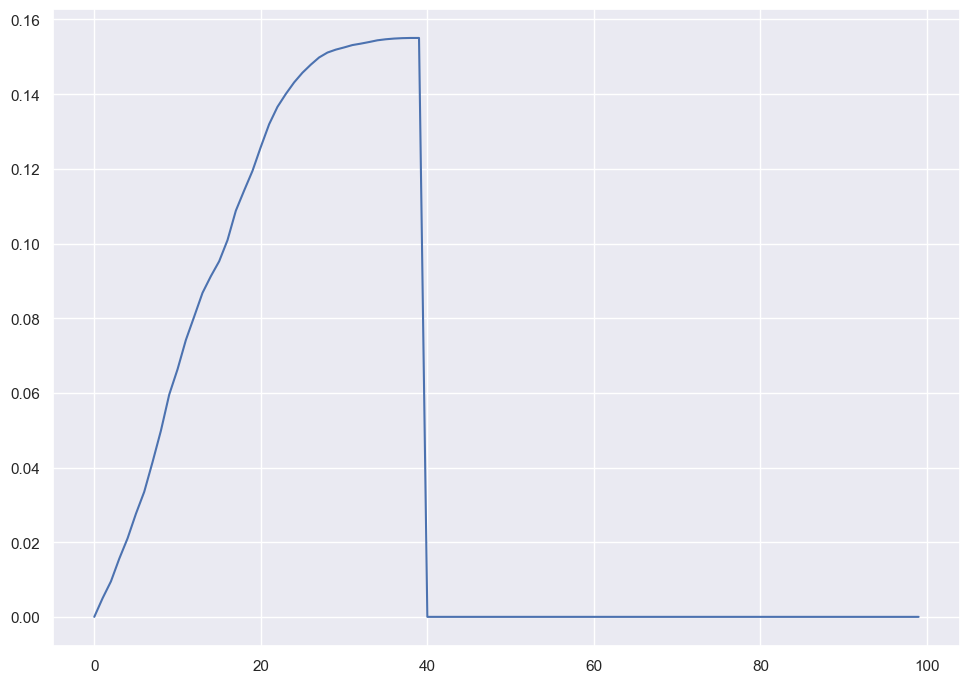

In [142]:

sns.lineplot(x=np.arange(V_track.shape[0]), y=V_track.mean(axis=1))

In [104]:
pi

{0: 1,
 1: 0,
 2: 2,
 3: 1,
 4: 1,
 5: 0,
 6: 1,
 7: 1,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0,
 15: 0,
 16: 1,
 17: 1,
 18: 0,
 19: 1,
 20: 1,
 21: 0,
 22: 1,
 23: 1,
 24: 0,
 25: 0,
 26: 0,
 27: 0,
 28: 0,
 29: 0,
 30: 0,
 31: 1,
 32: 1,
 33: 1,
 34: 1,
 35: 1,
 36: 1,
 37: 2,
 38: 1,
 39: 1,
 40: 0,
 41: 1,
 42: 0,
 43: 0,
 44: 3,
 45: 0,
 46: 0,
 47: 1,
 48: 1,
 49: 1,
 50: 1,
 51: 1,
 52: 1,
 53: 0,
 54: 1,
 55: 1,
 56: 0,
 57: 0,
 58: 0,
 59: 0,
 60: 0,
 61: 0,
 62: 2,
 63: 1,
 64: 1,
 65: 1,
 66: 2,
 67: 2,
 68: 1,
 69: 1,
 70: 1,
 71: 1,
 72: 0,
 73: 0,
 74: 0,
 75: 0,
 76: 0,
 77: 0,
 78: 0,
 79: 1,
 80: 2,
 81: 1,
 82: 0,
 83: 0,
 84: 2,
 85: 2,
 86: 2,
 87: 1,
 88: 0,
 89: 0,
 90: 0,
 91: 0,
 92: 3,
 93: 0,
 94: 1,
 95: 0,
 96: 0,
 97: 1,
 98: 0,
 99: 1,
 100: 0,
 101: 0,
 102: 0,
 103: 1,
 104: 0,
 105: 0,
 106: 2,
 107: 1,
 108: 0,
 109: 1,
 110: 0,
 111: 0,
 112: 2,
 113: 2,
 114: 1,
 115: 2,
 116: 1,
 117: 1,
 118: 2,
 119: 1,
 120: 0,
 121: 0,
 122: 0,
 12

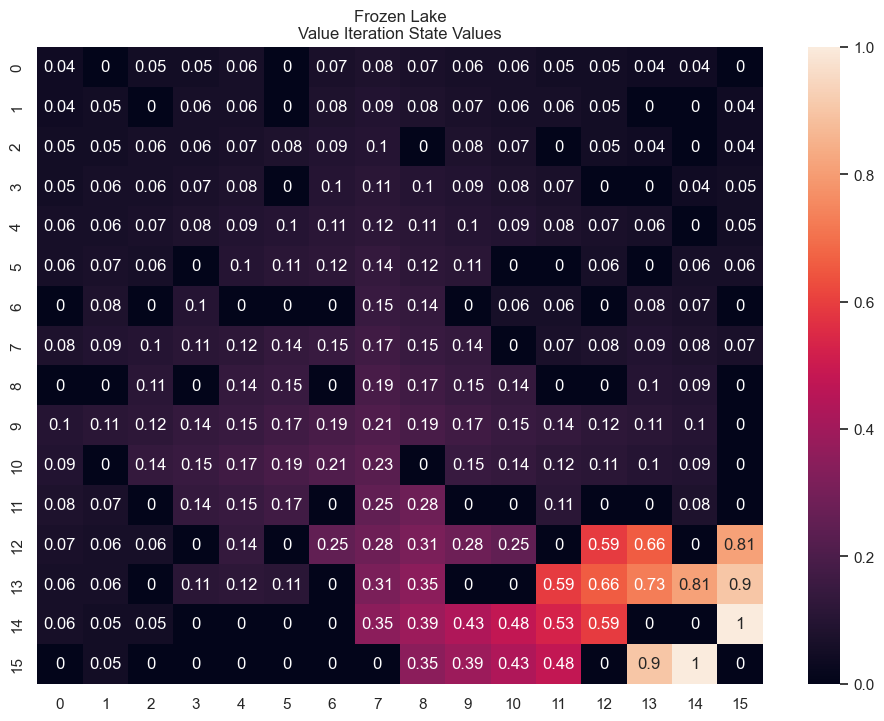

In [105]:

#plot state values
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})
size=(MAP_SIZE, MAP_SIZE)
Plots.values_heat_map(V, "Frozen Lake\nValue Iteration State Values", size)


In [127]:
v_max, directions = Plots.get_policy_map(pi, V, {0: "←", 1: "↓", 2: "→", 3: "↑"}, size)
Plots.plot_policy(v_max, directions=directions, map_size=size, title='whaaat!')

In [52]:
s_0, info = frozen_lake.reset(seed=RANDOM_SEED)

runtime = 0.00 seconds


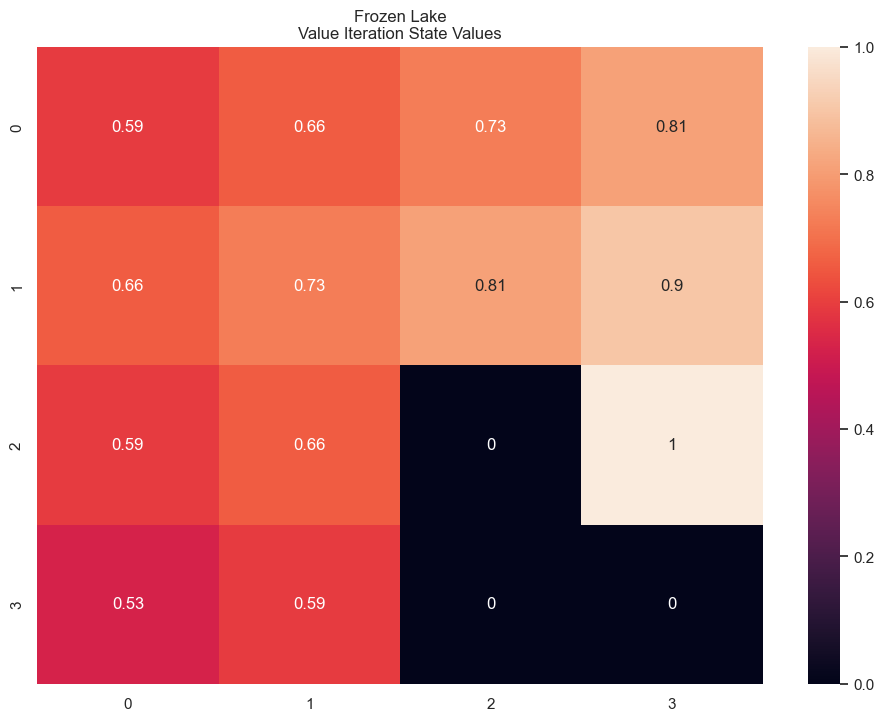

In [53]:

# run VI
V, V_track, pi = Planner(frozen_lake.P).policy_iteration(gamma=GAMMA, n_iters=N_ITERS, theta=THETA)

#plot state values
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})
size=(MAP_SIZE, MAP_SIZE)
Plots.values_heat_map(V, "Frozen Lake\nValue Iteration State Values", size)

In [143]:
from bettermdptools.utils.grid_search import GridSearch

In [146]:
MAP_SIZE = 40 # TODO: Increase to 16 later
P_FROZEN = 0. # Probability of tile being frozen
N_ITERS = 100
THETA = 1e-10 # Convergence threshold
GAMMA = 0.9 # Discount factor
RANDOM_SEED = 42

In [147]:
frozen_lake = gym.make('FrozenLake-v1', desc=generate_random_map(size=MAP_SIZE, p=P_FROZEN), is_slippery=False, render_mode="rgb_array")

# reset the map first
s_0, info = frozen_lake.reset(seed=RANDOM_SEED)

# run VI
# V, V_track, pi = Planner(frozen_lake.P).value_iteration(gamma=GAMMA, n_iters=N_ITERS, theta=THETA)

In [164]:
map_sizes = [16, 20]
p_frozen_values = [0.8, 0.9]
gamma_values = [0.9, 0.95]
n_iters_values = [100, 1000]
theta_values = [1e-10, 1e-3]

for grid_params in itertools.product(map_sizes, p_frozen_values, gamma_values, n_iters_values, theta_values):

    map_size, p_frozen, gamma, n_iters, theta = grid_params

    print(f"Running PI with map_size: {map_size}, p+frozen: {p_frozen}, gamma: {gamma},  n_iters:{n_iters}, theta:{theta}")
    
    env = gym.make('FrozenLake-v1', desc=generate_random_map(size=map_size, p=p_frozen), is_slippery=True)
    env.reset(seed=RANDOM_SEED)

    V, V_track, pi = Planner(env.P).policy_iteration(gamma=gamma, n_iters=n_iters, theta=theta)

    episode_rewards = TestEnv.test_env(env=env, n_iters=100, pi=pi)

    print("Avg. episode reward: ", np.mean(episode_rewards))
    print("###################")

Running PI with map_size: 16, p+frozen: 0.8, gamma: 0.9,  n_iters:100, theta:1e-10
runtime = 0.16 seconds
Avg. episode reward:  0.0
###################
Running PI with map_size: 16, p+frozen: 0.8, gamma: 0.9,  n_iters:100, theta:0.001
runtime = 0.04 seconds
Avg. episode reward:  0.04
###################
Running PI with map_size: 16, p+frozen: 0.8, gamma: 0.9,  n_iters:1000, theta:1e-10


c:\Users\pavan\anaconda3\envs\ml\Lib\site-packages\gymnasium\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


runtime = 0.16 seconds
Avg. episode reward:  0.08
###################
Running PI with map_size: 16, p+frozen: 0.8, gamma: 0.9,  n_iters:1000, theta:0.001
runtime = 0.04 seconds
Avg. episode reward:  0.0
###################
Running PI with map_size: 16, p+frozen: 0.8, gamma: 0.95,  n_iters:100, theta:1e-10
runtime = 0.34 seconds
Avg. episode reward:  0.0
###################
Running PI with map_size: 16, p+frozen: 0.8, gamma: 0.95,  n_iters:100, theta:0.001
runtime = 0.06 seconds
Avg. episode reward:  0.0
###################
Running PI with map_size: 16, p+frozen: 0.8, gamma: 0.95,  n_iters:1000, theta:1e-10
runtime = 0.86 seconds
Avg. episode reward:  0.01
###################
Running PI with map_size: 16, p+frozen: 0.8, gamma: 0.95,  n_iters:1000, theta:0.001
runtime = 0.08 seconds
Avg. episode reward:  0.0
###################
Running PI with map_size: 16, p+frozen: 0.9, gamma: 0.9,  n_iters:100, theta:1e-10
runtime = 0.24 seconds
Avg. episode reward:  0.27
###################
Running P

In [165]:
episode_rewards

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [166]:
env.reset(seed=RANDOM_SEED)

V, V_track, pi = Planner(env.P).policy_iteration(gamma=gamma, n_iters=n_iters, theta=theta)

runtime = 0.15 seconds


In [167]:
V_track.mean(axis=1)

array([0.        , 0.        , 0.00365844, 0.01157523, 0.02058323,
       0.02972299, 0.03488726, 0.04074123, 0.04386353, 0.0468627 ,
       0.0495724 , 0.05184372, 0.05319017, 0.05455889, 0.05529889,
       0.05614111, 0.05689601, 0.05730551, 0.05747528, 0.05757652,
       0.05762434, 0.05766942, 0.05771135, 0.05775026, 0.05778634,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [185]:
V_track[24, :]

array([2.42541071e-04, 4.38233718e-04, 6.70498089e-04, 8.64464043e-04,
       0.00000000e+00, 2.08895414e-03, 2.30675483e-03, 2.51887255e-03,
       2.74044432e-03, 2.99866665e-03, 3.30135402e-03, 3.60230343e-03,
       3.90077993e-03, 4.10280547e-03, 4.96408287e-03, 5.12786501e-03,
       5.25514476e-03, 5.38505671e-03, 5.49776527e-03, 5.54722473e-03,
       2.40220990e-04, 4.34289603e-04, 7.25024198e-04, 1.32557262e-03,
       1.77261381e-03, 2.23996947e-03, 2.49393569e-03, 2.72492763e-03,
       2.93875206e-03, 3.18792843e-03, 3.53704843e-03, 3.88611458e-03,
       4.32727321e-03, 0.00000000e+00, 5.59442747e-03, 5.82019889e-03,
       5.96441080e-03, 6.13180965e-03, 6.32539044e-03, 6.43209054e-03,
       2.06664973e-04, 3.61824230e-04, 0.00000000e+00, 1.64971805e-03,
       2.10325317e-03, 2.53422312e-03, 2.88599998e-03, 3.18425159e-03,
       3.38227154e-03, 3.55506715e-03, 4.00044810e-03, 4.35745641e-03,
       5.89227664e-03, 6.67307318e-03, 6.89340119e-03, 6.83101917e-03,
      